In [1]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as np
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import seaborn as sns
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

In [1]:
#ponte de conexão com o redshift
connection = psycopg2.connect(dbname="dw_amorsaude",
                  user="",
                  password="",
                  host ="amazonaws.com",
                  port = 5439)

NameError: name 'psycopg2' is not defined

In [3]:
#query
receita_bruta = 'select rf.data , count(*) as qtde_registro, sum(rf.total_recebido) as total_recebido from tb_consolidacao_receita_bruta_hist_final rf group by rf.data order by rf.data' 

In [4]:
df = pd.read_sql_query(receita_bruta,con=connection)
df['data'] = pd.to_datetime(df['data'])
df.set_index('data', inplace=True)

/tmp/ipykernel_78031/2579268054.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(receita_bruta,con=connection)


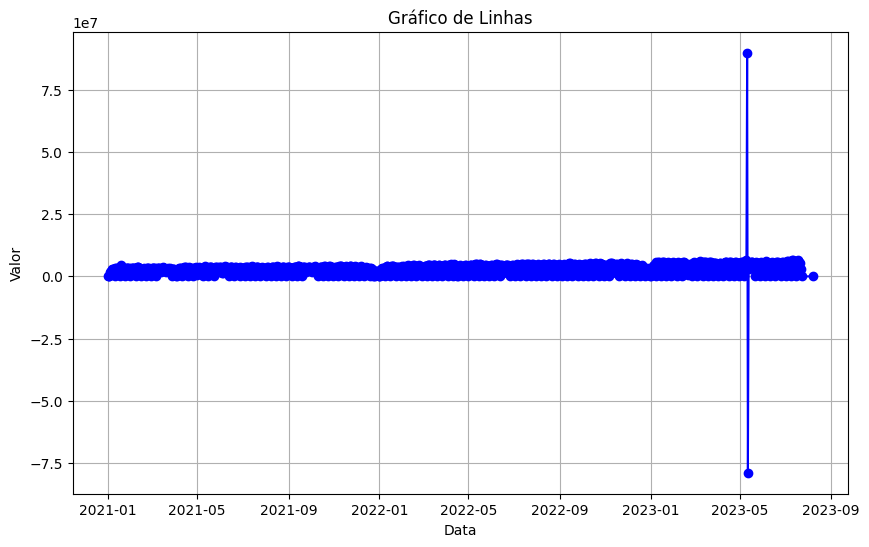

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['total_recebido'], marker='o', linestyle='-', color='blue')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Gráfico de Linhas')
plt.grid(True)
plt.show()

In [6]:
df1 = pd.read_sql_query(receita_bruta,con=connection)


/tmp/ipykernel_78031/2180129812.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql_query(receita_bruta,con=connection)


In [7]:
data_inicio1 = pd.to_datetime('2021-01-01')
data_fim2 = pd.to_datetime('2023-06-30')
df1 = df1[df1['data'].between(data_inicio1, data_fim2)]
df1['data'] = pd.to_datetime(df1['data'])

df1 = pd.DataFrame(df1)

df1.set_index('data', inplace=True)

/tmp/ipykernel_78031/3048780510.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df1 = df1[df1['data'].between(data_inicio1, data_fim2)]


In [8]:
df1

,qtde_registro,total_recebido
data,,
2021-01-01,3,61046.43
2021-01-02,78,40236.90
2021-01-03,3,0.01
2021-01-04,834,1672463.89
2021-01-05,893,2206462.16
...,...,...
2023-06-26,1896,5272346.30
2023-06-27,1916,5759783.61
2023-06-28,1923,5692899.81


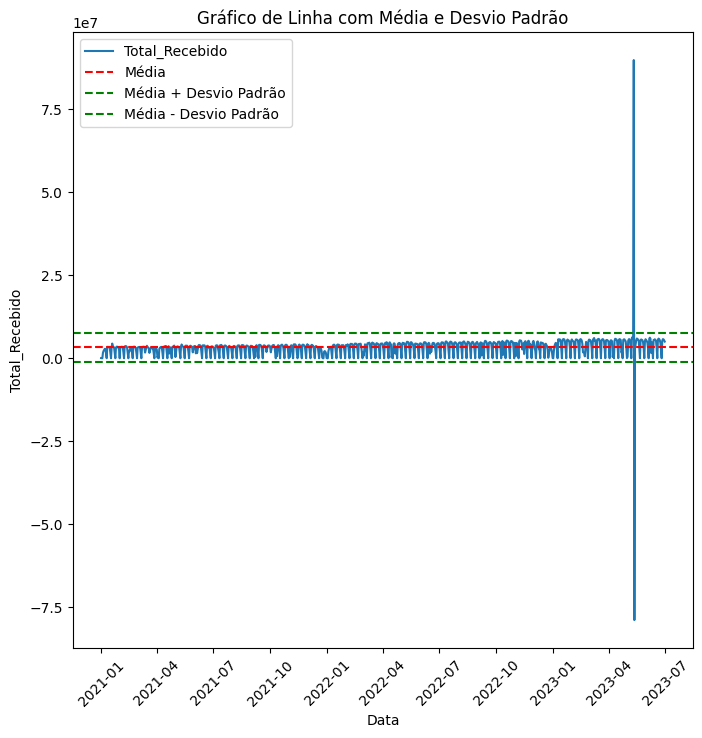

In [9]:
# Calcular a média e o desvio padrão dos valores de 'Total_Recebido'
mean = df1['total_recebido'].mean()
std = df1['total_recebido'].std()

# Plotar o gráfico de linha
plt.plot(df1['total_recebido'], label='Total_Recebido')

plt.axhline(mean, color='r', linestyle='--', label='Média')
plt.axhline(mean + std, color='g', linestyle='--', label='Média + Desvio Padrão')
plt.axhline(mean - std, color='g', linestyle='--', label='Média - Desvio Padrão')

# Configurar os rótulos e título do gráfico
plt.xlabel('Data')
plt.ylabel('Total_Recebido')
plt.title('Gráfico de Linha com Média e Desvio Padrão')

# Exibir a legenda
plt.legend()

# Girar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

In [10]:
#Separação do dataset, transformação em pd.data series, retirada de valores nulos e colocando em frequencia diária (reapontamento)
df1 = df1['total_recebido']
df1 = pd.DataFrame(df1)
df1['total_recebido'] = df1['total_recebido'].ffill()
df1 = df1.asfreq('D')
print(df1)

            total_recebido
data                      
2021-01-01        61046.43
2021-01-02        40236.90
2021-01-03            0.01
2021-01-04      1672463.89
2021-01-05      2206462.16
...                    ...
2023-06-26      5272346.30
2023-06-27      5759783.61
2023-06-28      5692899.81
2023-06-29      5404283.98
2023-06-30      5024834.16

[911 rows x 1 columns]


/tmp/ipykernel_78031/4068565417.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['total_recebido'], color="m", axlabel='Price')


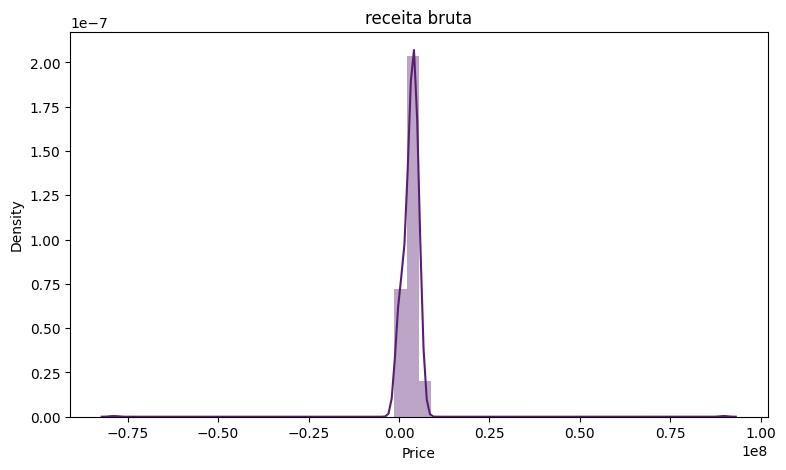

In [11]:
sns.set_color_codes(palette='dark')

f, ax = plt.subplots(figsize=(9, 5))
sns.distplot(df1['total_recebido'], color="m", axlabel='Price')
ax.set(title="receita bruta")
plt.show()

Testes estatisticos realizados com base em datas diarias

/home/gabriel/anaconda3/envs/.conda/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


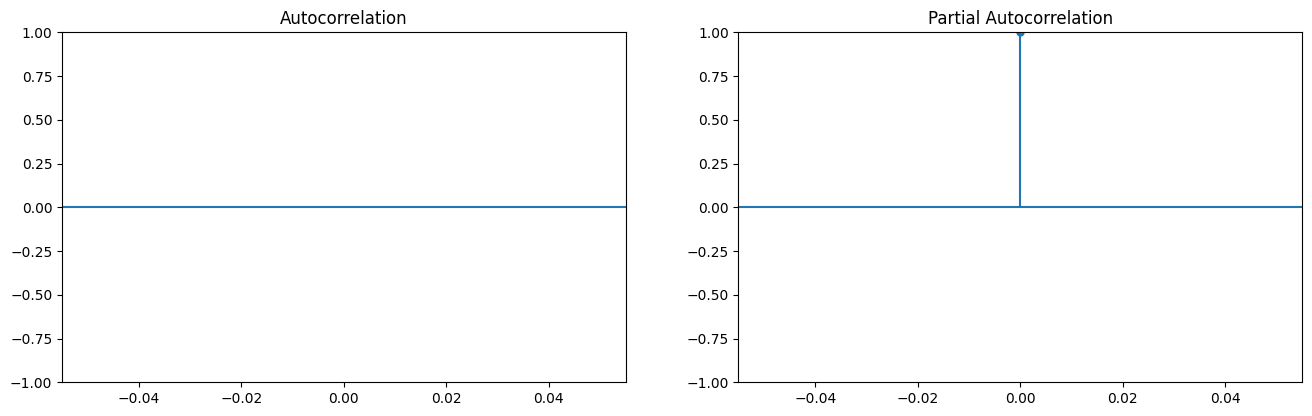

In [12]:
#correlação e autocorrelação de valores diários (série mensal não há dados suficientes)
def acf_pacf(x):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)
acf_pacf(df1["total_recebido"])

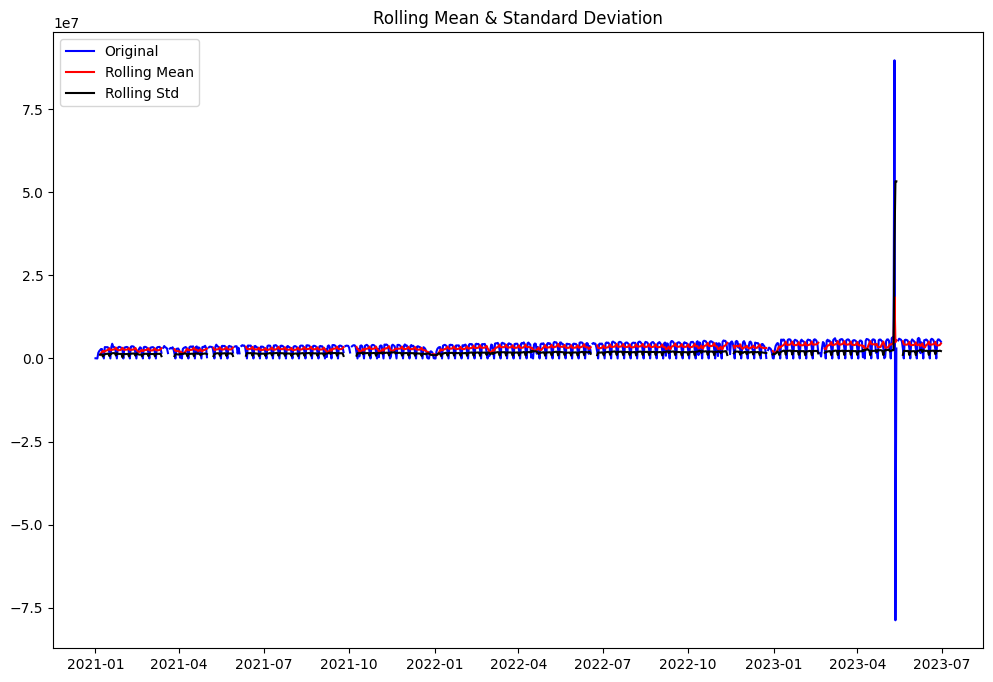

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [13]:
#Para verificar a estacionáriedade, podemos utilizar o teste ADF.
#O código abaixo cria uma função que irá realizar o teste em nossa variável chave, assim como plotar um gráfico com suas defasagens regredidas. 
def test_stationarity(timeseries, window = 6, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
test_stationarity(df1['total_recebido'])

In [14]:
#Decomposição das séries para analise estatística 
result = seasonal_decompose(df1['total_recebido'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(4, 6)

ValueError: This function does not handle missing values

In [15]:
#Verifica através da estatística de AIC qual melhor nível de parâmetros (p,d,q) para otimizar o modelo.
res = sm.tsa.arma_order_select_ic(df1["total_recebido"], ic=["aic", "bic"], trend="c")
res.aic_min_order
res.bic_min_order

(4, 2)

In [16]:
mod = sm.tsa.statespace.SARIMAX(df["total_recebido"],
                                order=(4, 2, 3),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18889D+01    |proj g|=  2.81773D+01

At iterate    5    f=  1.68520D+01    |proj g|=  4.33446D-01

At iterate   10    f=  1.67577D+01    |proj g|=  1.51177D-01

At iterate   15    f=  1.67426D+01    |proj g|=  5.09840D-02

At iterate   20    f=  1.67229D+01    |proj g|=  4.99845D-01

At iterate   25    f=  1.67077D+01    |proj g|=  8.00732D-02

At iterate   30    f=  1.66964D+01    |proj g|=  2.55235D-01
  ys=-3.716E-02  -gs= 2.951E-02 BFGS update SKIPPED

At iterate   35    f=  1.66284D+01    |proj g|=  1.05996D+00

At iterate   40    f=  1.66063D+01    |proj g|=  1.24848D+00

At iterate   45    f=  1.66043D+01    |proj g|=  3.08629D-01


/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.65985D+01    |proj g|=  4.25690D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    104      1     1     0   4.257D-01   1.660D+01
  F =   16.598478929066520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                      
Dep. Variable:                      total_recebido   No. Observations:                  923
Model:             SARIMAX(4, 2, 3)x(1, 1, [], 12)   Log Likelihood              -15320.396
Date:                             Mon, 24 Jul 2023   AIC                          306

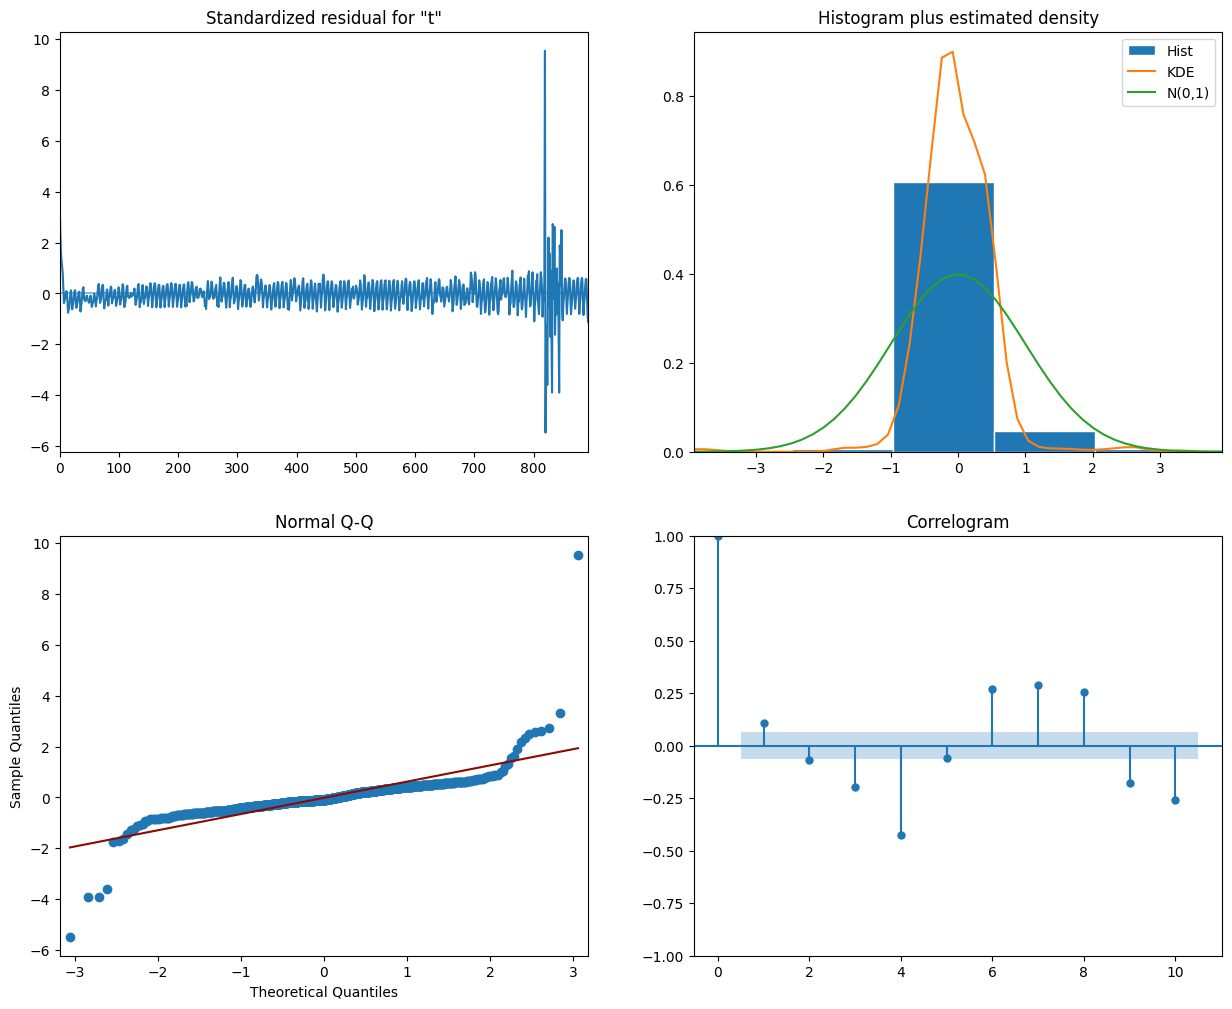

In [17]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

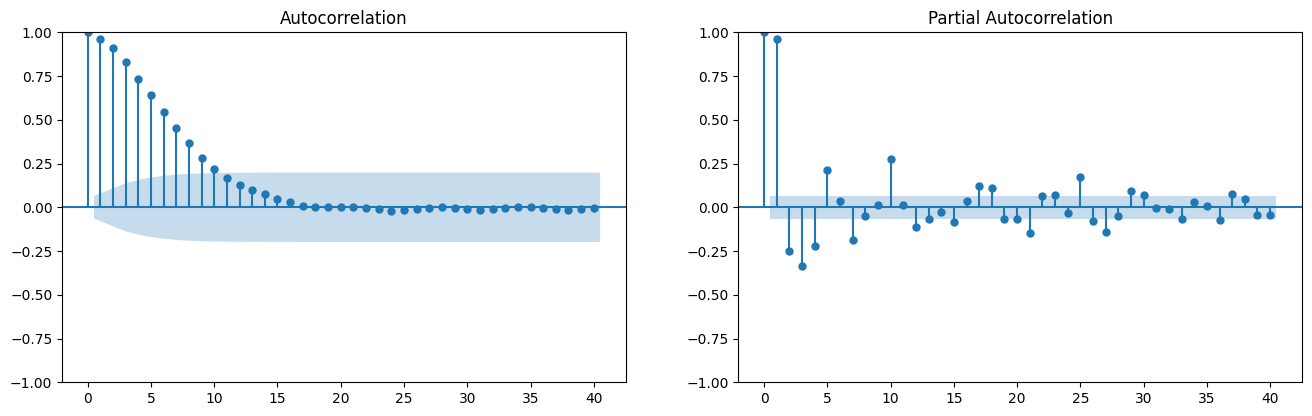

In [18]:

#gráfico de autocorrelação e autocorrelação parcial, indicando que os resíduos estão não autocorrelacionados, ou seja, são estacionários.
residuals = results.resid
acf_pacf(residuals)

In [19]:
print(results.mse)
print(results.mae)
print(results.sse)

1507731999423330.0
8107052.923678949
1.3916366354677335e+18


In [20]:
teste2 = results.forecast(96, alpha=0.05)
teste2.head()

/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


923    1.011773e+07
924    3.357995e+06
925    7.213541e+05
926   -1.898552e+05
927    6.331130e+06
Name: predicted_mean, dtype: float64

<Axes: >

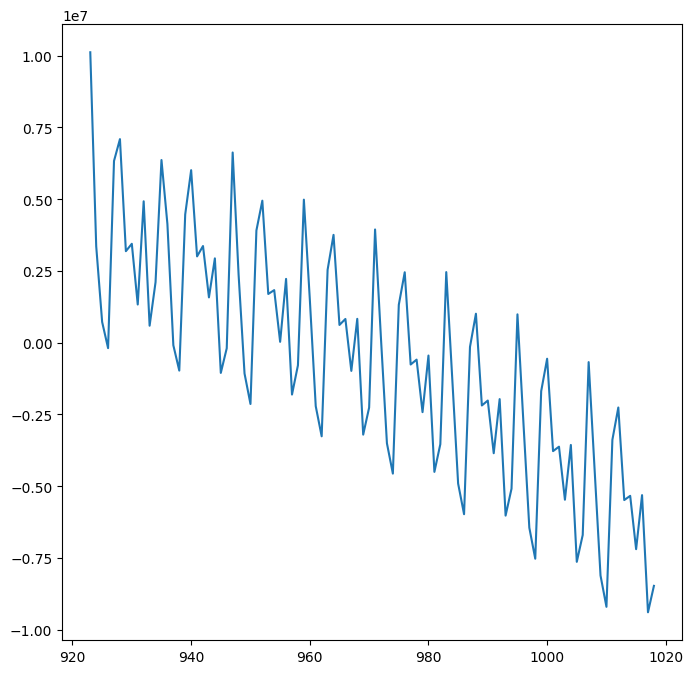

In [21]:
#Gráfico de projeção
teste2.plot()

In [22]:
#transformação da série de diário para mensal
df1_monthly = df1.resample('M').sum()
df1_monthly = df1_monthly.sort_values('data')
df1_monthly

,total_recebido
data,
2021-01-31,7.092307e+07
2021-02-28,7.164248e+07
2021-03-31,8.034041e+07
2021-04-30,7.471255e+07
2021-05-31,8.306378e+07
2021-06-30,8.525632e+07
2021-07-31,8.794483e+07
2021-08-31,8.843748e+07
2021-09-30,8.555364e+07


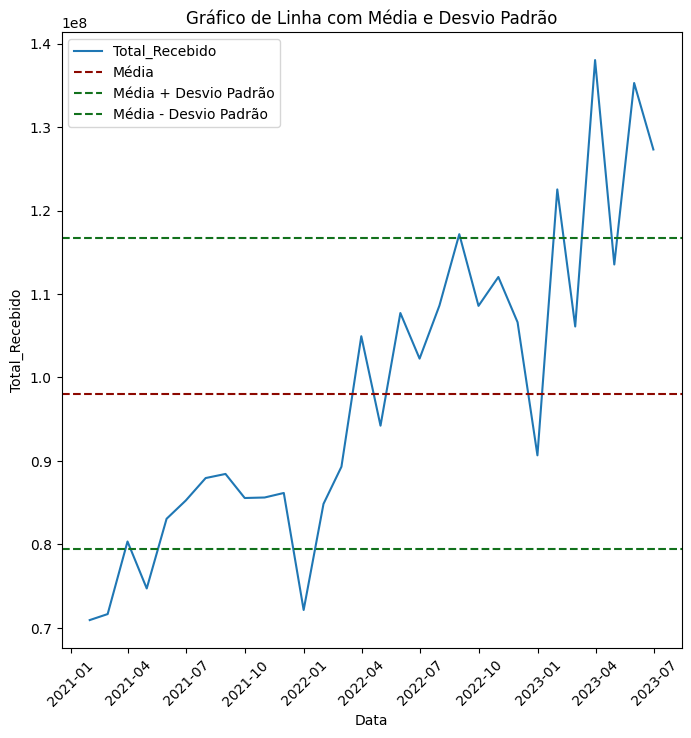

In [23]:
# Calcular a média e o desvio padrão dos valores de 'Total_Recebido'
mean = df1_monthly['total_recebido'].mean()
std = df1_monthly['total_recebido'].std()

# Plotar o gráfico de linha
plt.plot(df1_monthly['total_recebido'], label='Total_Recebido')

plt.axhline(mean, color='r', linestyle='--', label='Média')
plt.axhline(mean + std, color='g', linestyle='--', label='Média + Desvio Padrão')
plt.axhline(mean - std, color='g', linestyle='--', label='Média - Desvio Padrão')

# Configurar os rótulos e título do gráfico
plt.xlabel('Data')
plt.ylabel('Total_Recebido')
plt.title('Gráfico de Linha com Média e Desvio Padrão')

# Exibir a legenda
plt.legend()

# Girar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

<Axes: ylabel='total_recebido'>

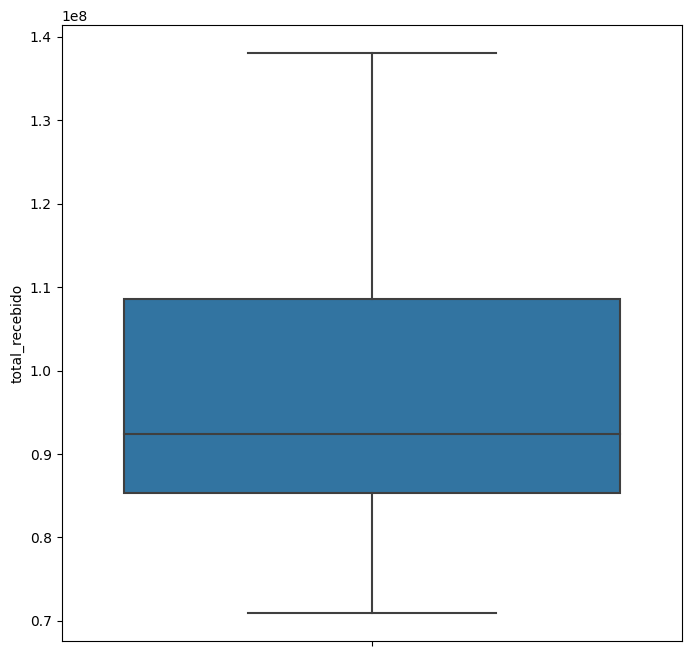

In [24]:
sns.boxplot(y="total_recebido", data=df1_monthly)

/tmp/ipykernel_78031/842440797.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1_monthly['total_recebido'], color="m", axlabel='Price')


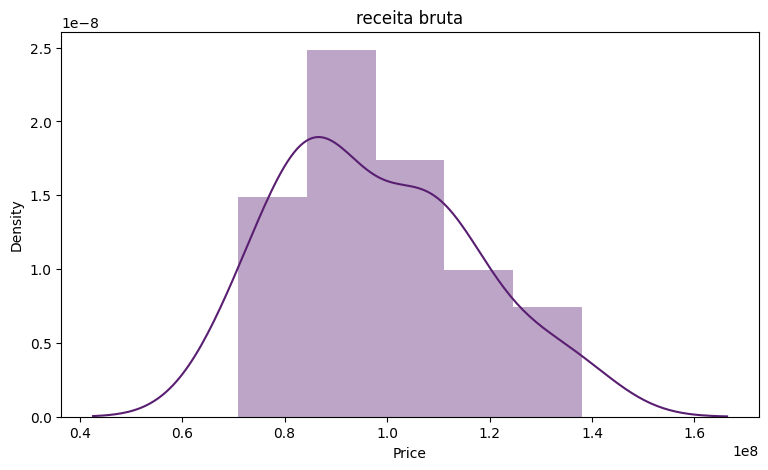

In [25]:
#distribuição da série mensal
sns.set_color_codes(palette='dark')

f, ax = plt.subplots(figsize=(9, 5))
sns.distplot(df1_monthly['total_recebido'], color="m", axlabel='Price')
ax.set(title="receita bruta")
plt.show()

<Figure size 800x800 with 0 Axes>

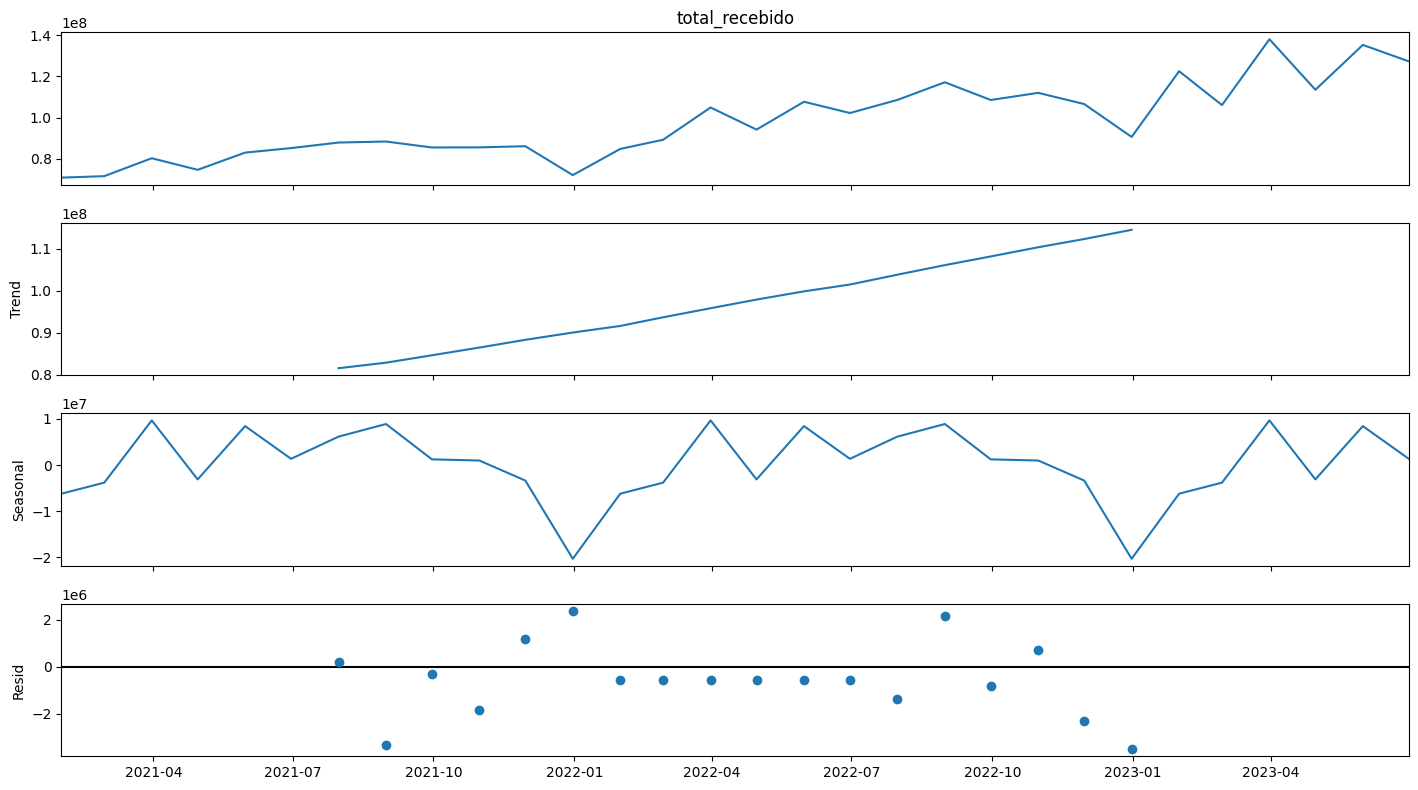

In [27]:
#Dados até 2022, sendo impossível realizar a decomposição pela falta de mais dados
result = seasonal_decompose(df1_monthly['total_recebido'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 8)

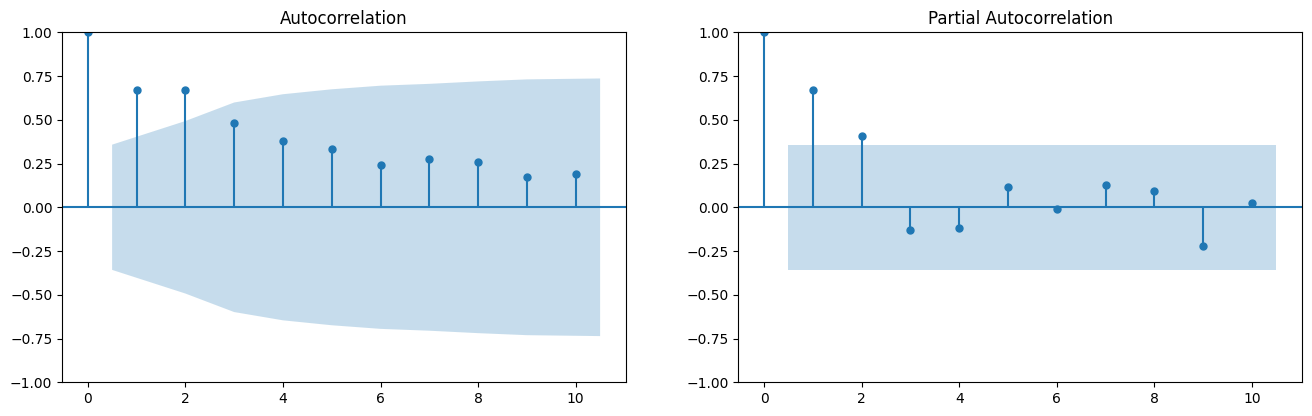

In [29]:
#correlação e autocorrelação de valores diários (série mensal não há dados suficientes)
def acf_pacf(x):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=10, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=10, ax=ax2)
acf_pacf(df1_monthly["total_recebido"])

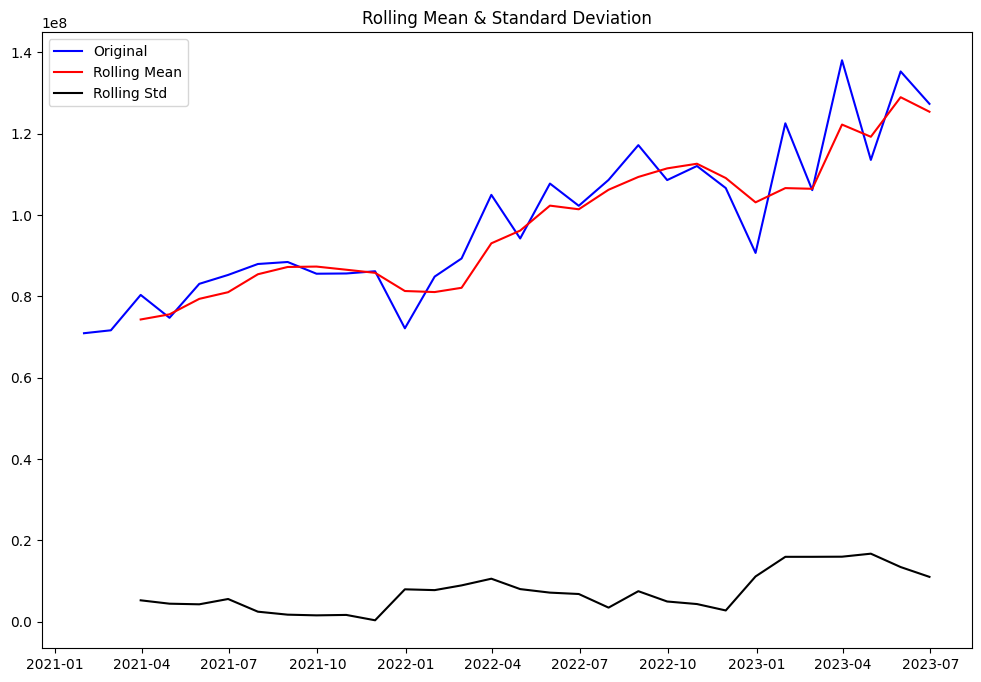

Results of Dickey-Fuller Test:


ValueError: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors

In [30]:
#Para verificar a estacionáriedade, podemos utilizar o teste ADF.
#O código abaixo cria uma função que irá realizar o teste em nossa variável chave, assim como plotar um gráfico com suas defasagens regredidas. 
def test_stationarity(timeseries, window = 3, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
test_stationarity(df1_monthly['total_recebido'])

In [31]:

#Verifica através da estatística de AIC qual melhor nível de parâmetros (p,d,q) para otimizar o modelo.
res = sm.tsa.arma_order_select_ic(df1_monthly["total_recebido"], ic=["aic", "bic"], trend="c")
res.aic_min_order
res.bic_min_order

/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gabriel/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0)

In [32]:
mod = sm.tsa.statespace.SARIMAX(df1_monthly["total_recebido"],
                                order=(2, 0, 3),
                                seasonal_order=(1, 1, 0, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_montlhly = mod.fit()

print(results_montlhly.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29838D+07    |proj g|=  6.13483D+06

At iterate    5    f=  1.73231D+01    |proj g|=  2.09551D+02

At iterate   10    f=  9.74286D+00    |proj g|=  5.86016D+00

At iterate   15    f=  9.52250D+00    |proj g|=  4.89598D-01

At iterate   20    f=  9.38043D+00    |proj g|=  4.65598D-01

At iterate   25    f=  9.26464D+00    |proj g|=  4.76772D-01

At iterate   30    f=  9.25703D+00    |proj g|=  6.77783D-02

At iterate   35    f=  9.23981D+00    |proj g|=  1.42045D-01

At iterate   40    f=  9.23838D+00    |proj g|=  2.05043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


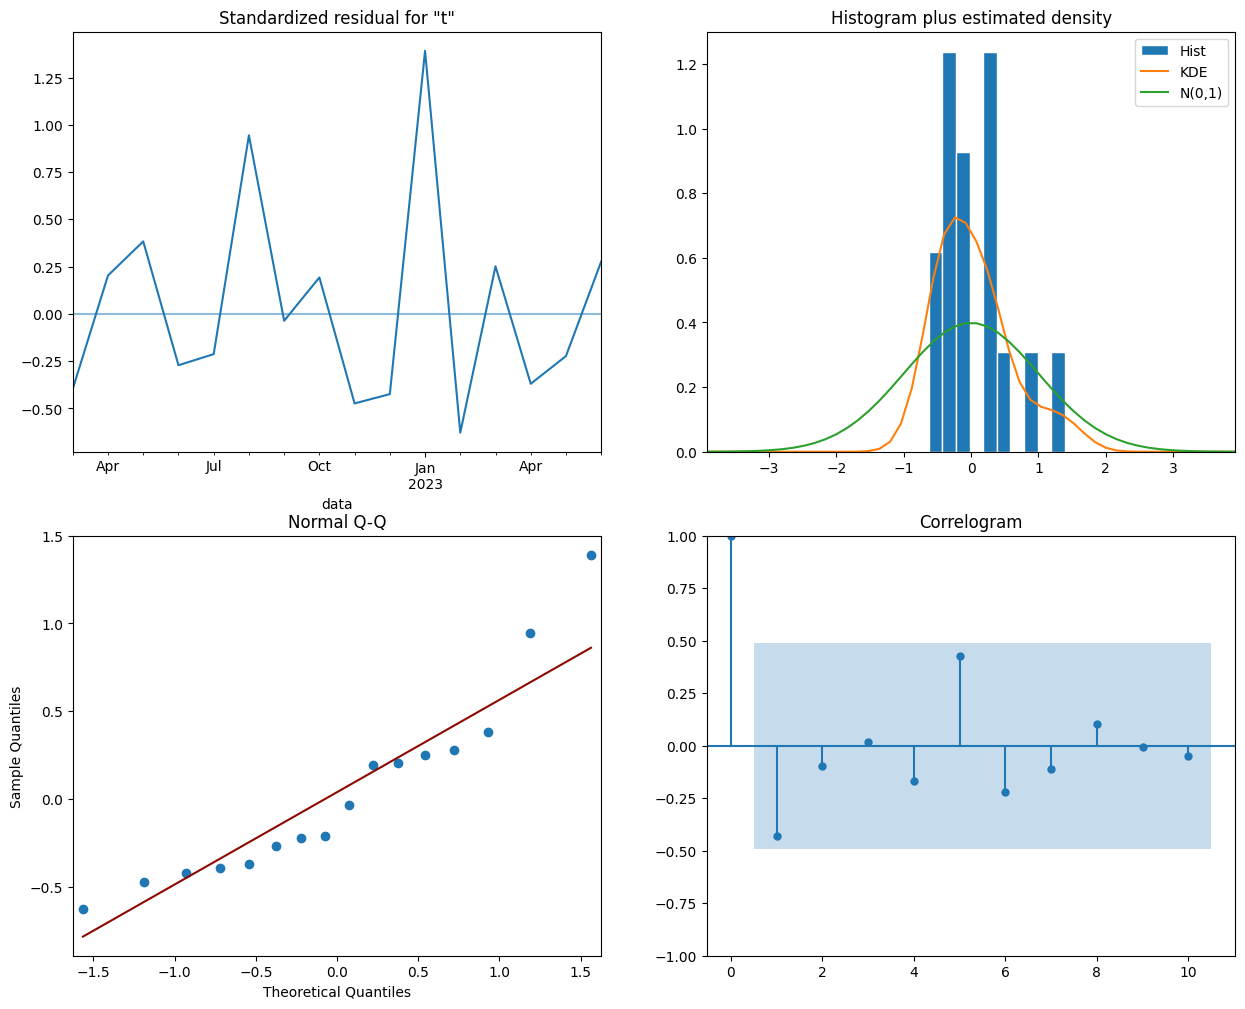

In [33]:
results_montlhly.plot_diagnostics(figsize=(15, 12))
plt.show()

In [34]:
print(results_montlhly.mse)
print(results_montlhly.mae)
print(results_montlhly.sse)

744732475837447.2
16962151.97837643
2.2341974275123416e+16


In [46]:
teste2_monthly = results_montlhly.forecast(96, alpha=0.05)
teste2_monthly.head(30)
teste2_monthly = teste2_monthly[:12]

<Axes: >

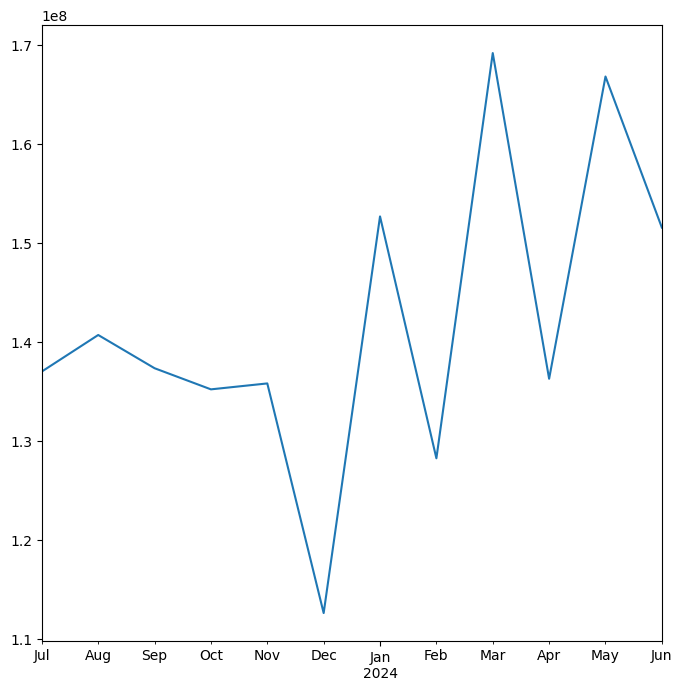

In [47]:
#Gráfico de projeção
teste2_monthly.plot()

In [48]:
nome_do_arquivo = 'projecao_AR.xlsx'
teste2_monthly.to_excel(nome_do_arquivo, index=False)  # O argumento 'index=False' evita salvar o índice do DataFrame no Excel

In [49]:
df1_monthly
nome_do_arquivo = 'df1_monthly.xlsx'
df1_monthly.to_excel(nome_do_arquivo, index=False)  # O argumento 'index=False' evita salvar o índice do DataFrame no Excel

In [ ]:
#Pesquisar depois como concatenar os dados projetados